# Rolling Futures Contracts

+ 1.1 Basic EDA (Exploratory Data Analysis)
  * 1.1.1 Initial Analysis <br>
  * 1.1.2 Checking the full dataset to see how its structured before rolling <br>
+ 1.2 Rolling Futures Contracts <br>
  * 1.2.1 Pandas Implementation - sample data <br>
  * 1.2.2 Dask Implementation - sample data <br>
  * 1.2.3 Rolling over entire dataset <br>
  * 1.2.4 Plotting to check rolling adjustment <br>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import dask.dataframe as dd

# EDA
## 1.1. Initial Analysis

In [85]:
h = h5py.File('ES.h5')

In [86]:
h['tick'].keys()

<KeysViewHDF5 ['trades', 'trades_filter0vol']>

In [96]:
tick = h.get('tick').get('trades')
print("Size:",tick.size)

Size: 903298560


In [97]:
tick[:20]

array([(b'ESU97', 933.75, b'19970910001318000', 0),
       (b'ESU97', 933.75, b'19970910010809000', 0),
       (b'ESU97', 934.  , b'19970910011146000', 0),
       (b'ESU97', 933.75, b'19970910011819000', 0),
       (b'ESU97', 933.75, b'19970910012349000', 0),
       (b'ESU97', 933.75, b'19970910012352000', 0),
       (b'ESU97', 934.  , b'19970910020654000', 0),
       (b'ESU97', 934.  , b'19970910020738000', 0),
       (b'ESU97', 934.  , b'19970910023013000', 0),
       (b'ESU97', 934.25, b'19970910025316000', 0),
       (b'ESU97', 934.  , b'19970910030444000', 0),
       (b'ESU97', 934.  , b'19970910033011000', 0),
       (b'ESU97', 934.  , b'19970910033011000', 0),
       (b'ESU97', 933.75, b'19970910040125000', 0),
       (b'ESU97', 933.5 , b'19970910040500000', 0),
       (b'ESU97', 933.5 , b'19970910040519000', 0),
       (b'ESU97', 933.25, b'19970910041001000', 0),
       (b'ESU97', 933.25, b'19970910041004000', 0),
       (b'ESU97', 933.5 , b'19970910041220000', 0),
       (b'ES

In [98]:
tick = h.get('tick').get('trades_filter0vol')
print("Size:",tick.size)

Size: 856183065


In [99]:
tick[:20]

array([(b'ESU03', 971.75, b'20030630230001000', 1),
       (b'ESU03', 972.  , b'20030630230005000', 1),
       (b'ESU03', 972.  , b'20030630230009000', 2),
       (b'ESU03', 971.75, b'20030630230141000', 3),
       (b'ESU03', 972.  , b'20030630230155000', 1),
       (b'ESU03', 972.  , b'20030630230157000', 1),
       (b'ESU03', 972.  , b'20030630230158000', 1),
       (b'ESU03', 972.  , b'20030630230417000', 3),
       (b'ESU03', 971.75, b'20030630230508000', 5),
       (b'ESU03', 971.75, b'20030630230509000', 5),
       (b'ESU03', 971.75, b'20030630230540000', 2),
       (b'ESU03', 971.5 , b'20030630230611000', 1),
       (b'ESU03', 971.75, b'20030630230611000', 1),
       (b'ESU03', 971.75, b'20030630230611000', 1),
       (b'ESU03', 971.75, b'20030630230619000', 2),
       (b'ESU03', 971.75, b'20030630230702000', 1),
       (b'ESU03', 971.75, b'20030630231032000', 1),
       (b'ESU03', 971.5 , b'20030630231214000', 1),
       (b'ESU03', 971.5 , b'20030630231257000', 1),
       (b'ES

We can see that the hdf5 file has two datasets and looking at the sample we can see that **trades_filter0vol** is the trade data as that non zero volume and that's what we'll be using further.

## 1.1.2 Checking the full dataset to see how its structured before rolling
Here we are checking the following
1) How each contracts are alligned in the datasets.
2) If there are prices for multiple contracts for same timestamps.
3) Wether the data is sorted

To be able to do this, we are going to group the entire tick dataset by the contracts and check the following above points.

In [36]:
df = dd.read_hdf("ES.h5",key='/tick/trades_filter0vol')

In [38]:
# basic data prep
df['timestamp'] = dd.to_datetime(df['Time'], format='%Y%m%d%H%M%S%f')
df.columns = [c.lower() for c in df.columns]
# # Since dask doesnt load the entire data, but data by partitions, the index would be reset for each partition, so we need to circumvent that part
# # https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.reset_index.html 
df['index'] = 1
df['index'] = df['index'].cumsum()-1

In [78]:
df_inst_grouped = df.groupby('instrument').agg({
                                                'timestamp': ['min', 'max'],
                                                'price': ['first', 'last'],
                                                'index': ['first', 'last'],
                                                'volume': ['sum'],}).compute()
df_inst_grouped = df_inst_grouped.reset_index()
df_inst_grouped.columns = ['instrument','time_start','time_end','price_start','price_end','index_start','index_end','vol_sum']
# df_inst_grouped.to_parquet('instruments_grouped.parquet')
# df_inst_grouped = pd.read_parquet('instruments_grouped.parquet')
df_inst_grouped.sort_values(by='index_start',inplace=True)

In [79]:
df_inst_grouped

,instrument,time_start,time_end,price_start,price_end,index_start,index_end,vol_sum
18,ESU03,2003-06-30 23:00:01.000,2003-09-10 15:14:59.000,971.75,1013.75,0,2984985,30489689
27,ESZ03,2003-09-10 15:45:00.000,2003-12-10 15:14:59.000,1012.00,1061.00,2984986,8352407,40058305
0,ESH04,2003-12-10 15:30:01.000,2004-03-10 15:14:59.000,1059.50,1120.00,8352408,14213072,35278977
9,ESM04,2004-03-10 15:30:00.000,2004-06-09 15:14:59.000,1119.50,1131.75,14213073,21565553,46476117
19,ESU04,2004-06-09 15:30:24.000,2004-09-08 15:14:59.000,1131.50,1118.75,21565554,27008946,37162712
28,ESZ04,2004-09-08 15:33:09.000,2004-12-08 15:14:59.000,1119.00,1184.25,27008947,32703626,41051152
1,ESH05,2004-12-08 15:30:00.000,2005-03-09 15:14:59.000,1185.50,1206.75,32703627,38264917,40365756
10,ESM05,2005-03-09 15:30:04.000,2005-06-08 15:14:59.000,1211.00,1195.75,38264918,45507018,52559450
20,ESU05,2005-06-08 15:30:50.000,2005-09-07 15:14:59.000,1200.75,1235.25,45507019,51537911,45766353
29,ESZ05,2005-09-07 15:30:05.000,2005-12-07 15:14:59.000,1241.75,1257.50,51537912,58697499,56275151


<Axes: xlabel='time_start'>

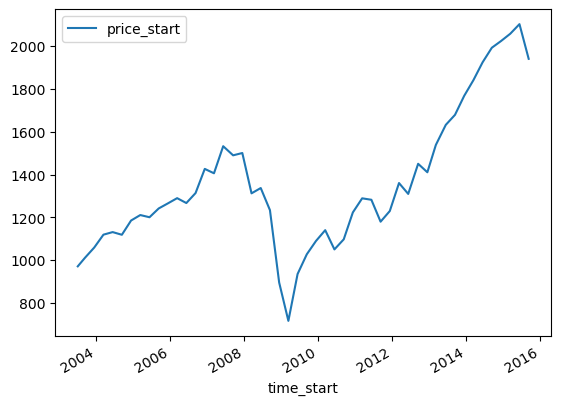

In [73]:
# plotting the start prices of each contract as a simple sanity check if its ordered
df_inst_grouped.plot(x='time_start',y='price_start')

In [75]:
contract_month_code = ['F','G','H','J','K','M','N','Q','U','V','X','Z']
contract_month_code_dict = dict(map(lambda i,j : (i,j) , contract_month_code,np.arange(1,13)))

df_inst_grouped['expiry_month'] =  (df_inst_grouped['instrument'].str[2].replace(contract_month_code_dict)).astype(str)+'-01-20'+(df_inst_grouped['instrument'].str[-2:]).astype(str)
df_inst_grouped['expiry_month'] = pd.to_datetime(df_inst_grouped['expiry_month'])
df_inst_grouped.head()


,instrument,time_start,time_end,price_start,price_end,index_start,index_end,vol_sum,expiry_month
18,ESU03,2003-06-30 23:00:01,2003-09-10 15:14:59,971.75,1013.75,0,2984985,30489689,2003-09-01
27,ESZ03,2003-09-10 15:45:00,2003-12-10 15:14:59,1012.00,1061.00,2984986,8352407,40058305,2003-12-01
0,ESH04,2003-12-10 15:30:01,2004-03-10 15:14:59,1059.50,1120.00,8352408,14213072,35278977,2004-03-01
9,ESM04,2004-03-10 15:30:00,2004-06-09 15:14:59,1119.50,1131.75,14213073,21565553,46476117,2004-06-01
19,ESU04,2004-06-09 15:30:24,2004-09-08 15:14:59,1131.50,1118.75,21565554,27008946,37162712,2004-09-01


In [76]:
# Checking if the contract expiry months are in increasing order to see if the data is sorted 
assert(df_inst_grouped['expiry_month'].is_monotonic)

In [77]:
# checking if there's an overlapping timestamps for each contracts.
assert(all(df_inst_grouped['time_start'].iloc[1:]>df_inst_grouped['time_end'].shift().dropna()))

## 1.2. Adjusting the Futures Contracts
Now we know that the datasets are sorted and has no overlapping contracts. The dataset has already decided rolling dates for the contracts so we don't have do an analysis of the volume or other parameters to decide when we are switching over the new contracts. Therefore, we are just focusing on doing a backward arjustments of the price to get a continous time series without any price jumps on the rollover dates. 

We'll first roll the contracts using the ETF trick from the book [Advances in Financial Machine Learning by Marcos Lopez de Prado](https://www.amazon.in/Advances-Financial-Machine-Learning-Marcos/dp/1119482089) (2.4.3) on a small sample of last two contracts. <br>
Then we'll implement the same algorithm in dask on the small sample to verify the implementation in pandas and Dask has the same results. <br>
Then we'll run it on the entire historical data

In [82]:
df = dd.read_hdf("ES.h5",key='/tick/trades_filter0vol')

In [83]:
# data prep
df['timestamp'] = dd.to_datetime(df['Time'], format='%Y%m%d%H%M%S%f')
df.columns = [c.lower() for c in df.columns]
df['dollar_volume'] = df['price'] * df['volume']

In [84]:
# taking the last 10 partitions and converting to a pandas dataframe
df_pd = df.partitions[df.npartitions-10:].compute() 
df_pd.reset_index(inplace=True)

In [85]:
df_pd['instrument'].unique()

array(['ESU15', 'ESZ15'], dtype=object)

### 1.2.1 Pandas Implementation - sample dataset

In [86]:
# ETF trick rolling algorithm from the book AFML
def rollGaps(series,diction={'Instrument':'instrument','Open':'price','Close':'price'},matchEnd=True):
    # Compute gaps at each roll, between previous close and next open
    rollDates = series[diction['Instrument']].drop_duplicates(keep='first').index
    gaps = series[diction['Close']]*0
    iloc = list(series.index)
    iloc = [iloc.index(i)-1 for i in rollDates] # index if dates prior to roll
    gaps.loc[rollDates[1:]] = series[diction['Open']].loc[rollDates[1:]] - series[diction['Close']].iloc[iloc[1:]].values
    gaps = gaps.cumsum()
    last_adjusted_gap = gaps.iloc[-1]
    if matchEnd:gaps -= gaps.iloc[-1] # roll backward
    return gaps, last_adjusted_gap

In [87]:
df_pd['gap'], last_adjusted_gap = rollGaps(df_pd)
df_pd['rolled_price'] = df_pd['price'] - df_pd['gap'] # adjusting the price with the gap

In [88]:
last_adjusted_gap

-12.0

The reason why we need the gap for the last contract adjustment is because when we do the rolling over all the entire data, its much quicker if we pass in this last adjusted gap value.

#### Plotting the rolling effect

In [89]:
df_pd[df_pd['instrument']!=df_pd['instrument'].shift(1)]

,index,instrument,price,time,volume,timestamp,dollar_volume,gap,rolled_price
0,0,ESU15,1929.0,20150825084516712,5,2015-08-25 08:45:16.712,9645.0,12.0,1917.0
4050729,50729,ESZ15,1939.5,20150910170000021,10,2015-09-10 17:00:00.021,19395.0,0.0,1939.5


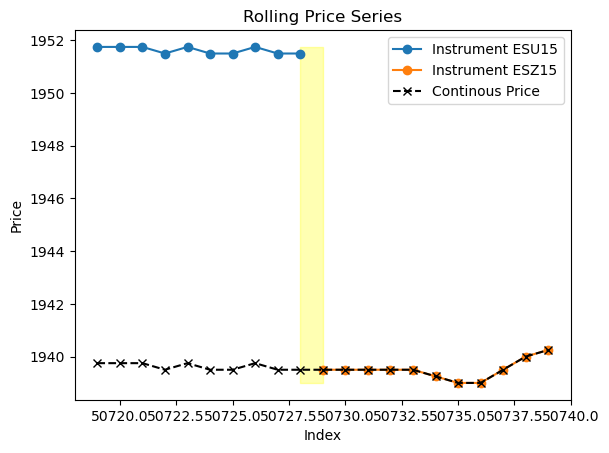

In [90]:
int_index = 4050729
df_plot = df_pd.loc[int_index-10:int_index+10]

fig, ax = plt.subplots()
# Iterate through unique values of 'instrument' column
for instrument in df_plot['instrument'].unique():
    group = df_plot[df_plot['instrument'] == instrument]
    # Plot each group with a different color
    ax.plot(group['index'], group['price'], label=f'Instrument {instrument}', marker='o')
# Plot the second series from the 'new_price' column
ax.plot(df_plot['index'], df_plot['rolled_price'], label='Continous Price', linestyle='--', color='black', marker='x')
# Identify the gap between instrument A and B
last_index_A = df_plot[df_plot['instrument'] == df_plot['instrument'].unique()[0]]['index'].max()
first_index_B = df_plot[df_plot['instrument'] == df_plot['instrument'].unique()[1]]['index'].min()
# Highlight the gap between instrument A and B
ax.fill_betweenx(y=[df_plot['price'].min(), df_plot['price'].max()], x1=last_index_A, x2=first_index_B, color='yellow', alpha=0.3)
# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Price')
ax.set_title('Rolling Price Series')
ax.legend()
plt.show()

### 1.2.2 Dask Implementation - sample dataset
The implementation had to be slightly modified to avoid unecessary full data scan in between. Making sure its the same as the original implementation from the book. 

In [92]:
df_dd = df.partitions[df.npartitions-10:] # taking the last 10 partitions from the original big dataframe

In [93]:
def roll_gaps_dd(series):
    series['gap']=0
    series['gap'] = series['gap'].mask((series['instrument']!=series['instrument'].shift(1)),series['price']-series['price'].shift(1)) 
    series['gap'] = series['gap'].fillna(0)
    series['gap'] = series['gap'].cumsum()
    series['gap'] -= last_adjusted_gap
    return series['gap']

In [94]:
df_dd['gap']= roll_gaps_dd(df_dd)
df_dd['rolled_price'] = df_dd['price'] - df_dd['gap'] # adjusting the price with the gap

In [95]:
df_dd = df_dd.compute()
df_dd.reset_index(inplace=True)

In [113]:
# making sure that the column types are same. 
for c in df_dd.columns:
    df_dd[c] = df_dd[c].astype(df_pd[c].dtype)

In [114]:
# making sure that both the pandas and dask implementation produces the same result
assert(df_pd.equals(df_dd))

True

In [119]:
assert(all(df_pd['rolled_price'] == df_dd['rolled_price'])) # the rolled prices are same

In [120]:
df_dd.head()

,index,instrument,price,time,volume,timestamp,dollar_volume,gap,rolled_price
0,0,ESU15,1929.00,20150825084516712,5,2015-08-25 08:45:16.712,9645.00,12.0,1917.00
1,1,ESU15,1929.25,20150825084516779,1,2015-08-25 08:45:16.779,1929.25,12.0,1917.25
2,2,ESU15,1929.25,20150825084516870,1,2015-08-25 08:45:16.870,1929.25,12.0,1917.25
3,3,ESU15,1929.25,20150825084516928,1,2015-08-25 08:45:16.928,1929.25,12.0,1917.25
4,4,ESU15,1929.00,20150825084516955,7,2015-08-25 08:45:16.955,13503.00,12.0,1917.00


## 1.2.3 Running the rolling over process over the entire dataset

In [121]:
last_adjusted_gap = -12.0

In [6]:
df = dd.read_hdf("ES.h5",key='/tick/trades_filter0vol')

In [7]:
# data preprocessing
df['timestamp'] = dd.to_datetime(df['Time'], format='%Y%m%d%H%M%S%f')
df.columns = [c.lower() for c in df.columns]
# # Since dask doesnt load the entire data, but data by partitions, the index would be reset for each partition, so we need to circumvent that part
# # https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.reset_index.html 
df['index'] = 1
df['index'] = df['index'].cumsum()-1

In [8]:
def roll_gaps_dd(series):
    series['gap']=0
    series['gap'] = series['gap'].mask((series['instrument']!=series['instrument'].shift(1)),series['price']-series['price'].shift(1)) 
    series['gap'] = series['gap'].fillna(0)
    series['gap'] = series['gap'].cumsum()
    series['gap'] -= last_adjusted_gap
    return series['gap']

In [9]:
df['gap']= roll_gaps_dd(df)
df['rolled_price'] = df['price'] - df['gap'] # adjusting the price with the gap
df['dollar_volume'] = df['rolled_price'] * df['volume']

In [11]:
# incase if you want to observe the job on the dask monitor dashboard
from dask.distributed import Client
client = Client() 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49742,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.75 GiB
Comm: tcp://127.0.0.1:49778,Total threads: 2
Dashboard: http://127.0.0.1:49780/status,Memory: 3.94 GiB
Nanny: tcp://127.0.0.1:49745,


In [8]:
# df.to_parquet('continous_tick_data.parquet')

Checking if any of the rolled price is below 0. If thats the case then we have to create the price from returns to avoid negative prices like mentioned in the AFML book (Snippet 2.3)

In [4]:
len(df[df['rolled_price']<0].compute())

0

## 1.2.4 Checks
#### Plotting contract transition to make sure that the continous time series is correctly created

In [122]:
df = dd.read_parquet('continous_tick_data.parquet')

In [123]:
df_test = df.partitions[df.npartitions-50:].compute()
df_test.reset_index(inplace=True)

In [124]:
df_test[df_test['instrument']!=df_test['instrument'].shift(1)]

,level_0,instrument,price,time,volume,timestamp,index,gap,rolled_price,dollar_volume
0,0,ESH15,2031.75,20150113053732925,1,2015-01-13 05:37:32.925,807000000,-11.50,2043.25,2043.25
20140901,140901,ESM15,2056.50,20150312170000021,1,2015-03-12 17:00:00.021,827140901,-19.25,2075.75,2075.75
30922627,922627,ESU15,2101.25,20150611170000021,46,2015-06-11 17:00:00.021,837922627,-28.25,2129.50,97957.00
44050729,50729,ESZ15,1939.50,20150910170000021,10,2015-09-10 17:00:00.021,851050729,-40.25,1979.75,19797.50


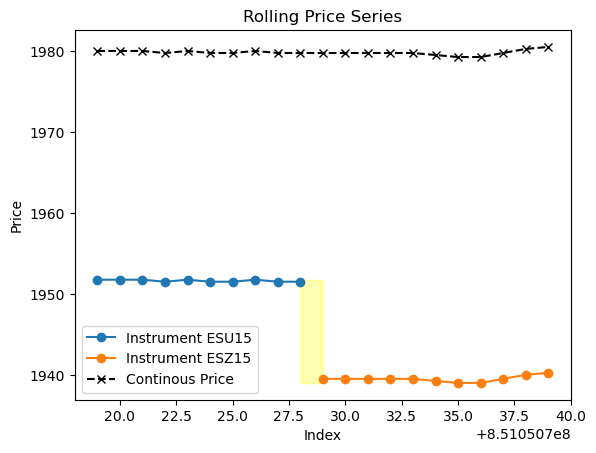

In [125]:
int_index = 44050729
df_plot = df_test.loc[int_index-10:int_index+10]

fig, ax = plt.subplots()
# Iterate through unique values of 'instrument' column
for instrument in df_plot['instrument'].unique():
    group = df_plot[df_plot['instrument'] == instrument]
    # Plot each group with a different color
    ax.plot(group['index'], group['price'], label=f'Instrument {instrument}', marker='o')
# Plot the second series from the 'new_price' column
ax.plot(df_plot['index'], df_plot['rolled_price'], label='Continous Price', linestyle='--', color='black', marker='x')
# Identify the gap between instrument A and B
last_index_A = df_plot[df_plot['instrument'] == df_plot['instrument'].unique()[0]]['index'].max()
first_index_B = df_plot[df_plot['instrument'] == df_plot['instrument'].unique()[1]]['index'].min()
# Highlight the gap between instrument A and B
ax.fill_betweenx(y=[df_plot['price'].min(), df_plot['price'].max()], x1=last_index_A, x2=first_index_B, color='yellow', alpha=0.3)
# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Price')
ax.set_title('Rolling Price Series')
ax.legend()
plt.show()

#### Plotting adjusted vs unadjusted price time bars 

In [127]:
df_timebars = df_test.set_index('timestamp').resample('D').agg({'price': 'ohlc',
                                        'volume': 'sum','instrument':'min'})
df_timebars.columns = ['open','close','high','low','volume','instrument']
df_timebars.reset_index(inplace=True)
df_timebars.dropna(inplace=True)
df_timebars[df_timebars['instrument']!=df_timebars['instrument'].shift(1)]

,timestamp,open,close,high,low,volume,instrument
0,2015-01-13,2031.75,2051.75,2001.0,2007.25,2417402,ESH15
59,2015-03-13,2059.25,2061.25,2032.5,2043.25,1211690,ESM15
150,2015-06-12,2097.25,2101.00,2082.0,2084.75,1130616,ESU15
241,2015-09-11,1946.75,1952.50,1927.5,1952.25,931964,ESZ15


In [128]:
df_timebars_adj = df_test.set_index('timestamp').resample('D').agg({'rolled_price': 'ohlc',
                                        'volume': 'sum','instrument':'min'})
df_timebars_adj.columns = ['open','close','high','low','volume','instrument']
df_timebars_adj.reset_index(inplace=True)
df_timebars_adj.dropna(inplace=True)
df_timebars_adj[df_timebars_adj['instrument']!=df_timebars['instrument'].shift(1)]

,timestamp,open,close,high,low,volume,instrument
0,2015-01-13,2043.25,2063.25,2012.50,2018.75,2417402,ESH15
59,2015-03-13,2078.50,2080.50,2051.75,2062.50,1211690,ESM15
150,2015-06-12,2125.50,2129.25,2110.25,2113.00,1130616,ESU15
241,2015-09-11,1987.00,1992.75,1967.75,1992.50,931964,ESZ15


In [130]:
# combining adjusted and unadjusted prices in one pandas dataframe
df_combined = pd.merge(
left = df_timebars[['timestamp','close','instrument']].rename({'close':'price'},axis=1),
right = df_timebars_adj[['timestamp','close']].rename({'close':'rolled_price'},axis=1),
left_on = 'timestamp',
right_on = 'timestamp',
how = 'left'
)

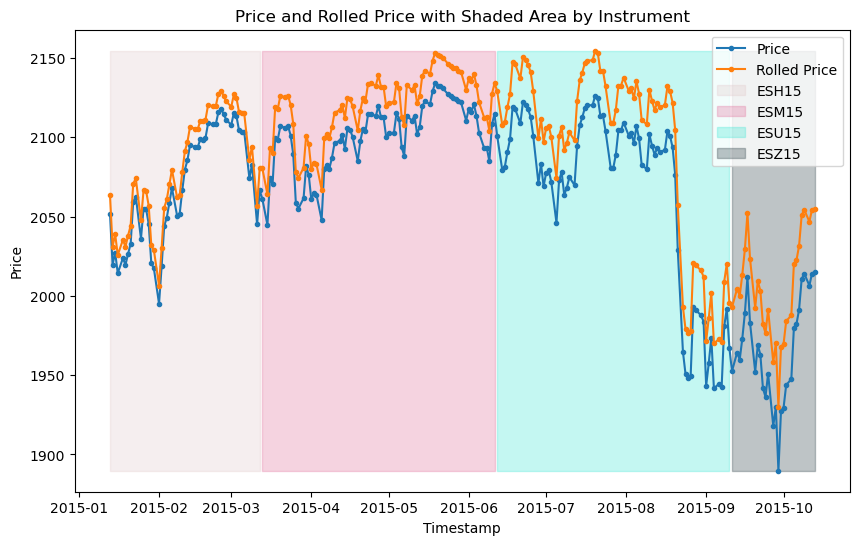

In [137]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting price and rolled_price
ax.plot(df_combined['timestamp'], df_combined['price'], label='Price',marker='.')
ax.plot(df_combined['timestamp'], df_combined['rolled_price'], label='Rolled Price',marker='.')

# Shade the chart area based on the instrument
for instrument, group in df_combined.groupby('instrument'):
    random_color = np.random.rand(3,)
    ax.fill_between(group['timestamp'], df_combined['price'].min(), df_combined['rolled_price'].max(), color=random_color, alpha=0.3, label=f'{instrument}')

# Customize the plot
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.title('Price and Rolled Price with Shaded Area by Instrument')
plt.show()
